# **IMPORT DATA**

In [1]:
import pandas as pd
train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


                 id      target
count  10876.000000  7613.00000
mean    5437.500000     0.42966
std     3139.775098     0.49506
min        0.000000     0.00000
25%     2718.750000     0.00000
50%     5437.500000     0.00000
75%     8156.250000     1.00000
max    10875.000000     1.00000


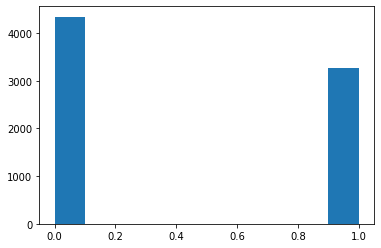

In [2]:
data = pd.concat([train_data,test_data],axis=0)
print(data.describe())
import matplotlib.pyplot as plt
plt.hist(data.target)
plt.show()

# **TEXT PREPROCESSING**

In [3]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [4]:
import spacy
nlp = spacy.load('en')
def preprocessing(text):
  text = text.replace('#','')
  text = decontracted(text)
  text = re.sub('\S*@\S*\s?','',text)
  text = re.sub('http[s]?:(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)

  token=[]
  result=''
  text = re.sub('[^A-z]', ' ',text.lower())
  
  text = nlp(text)
  for t in text:
    if not t.is_stop and len(t)>2:  
      token.append(t.lemma_)
  result = ' '.join([i for i in token])

  return result.strip()

In [5]:
data.text = data.text.apply(lambda x : preprocessing(x))

# **USING PRE-TRAINED GLOVE WEIGHTS**

In [6]:
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [7]:
corpus=create_corpus(data)

100%|██████████| 10876/10876 [00:02<00:00, 4403.06it/s]


In [8]:
import numpy as np
embedding_dict={}
with open('../input/glove6b200d/glove.6B.200d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_LEN=40
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

Using TensorFlow backend.


In [10]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 14093


In [11]:

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,200))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 14093/14093 [00:00<00:00, 143696.98it/s]


# **IMPLEMENTING MODEL**

In [12]:
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
model=Sequential()

embedding=Embedding(num_words,200,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2))


model.add(Dense(1, activation='sigmoid'))



optimzer=Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 200)           2818800   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,886,705
Trainable params: 67,905
Non-trainable params: 2,818,800
_________________________________________________________________


# **USING CALLBACKS**

In [13]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)
callbacks_list = [checkpoint,es]

In [14]:

tweet =data.iloc[:7613,:]
test = data.iloc[7613:,:]

In [15]:

train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6090, 40)
Shape of Validation  (1523, 40)


In [17]:
history=model.fit(X_train,y_train,batch_size=100,epochs=20,callbacks=callbacks_list,validation_data=(X_test,y_test),verbose=1)

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
6090/6090 [==============================] - 5s 777us/step - loss: 0.6063 - accuracy: 0.6759 - val_loss: 0.4757 - val_accuracy: 0.7905

Epoch 00001: val_accuracy improved from -inf to 0.79054, saving model to weights-improvement-01-0.79.hdf5
Epoch 2/20
6090/6090 [==============================] - 4s 609us/step - loss: 0.4999 - accuracy: 0.7760 - val_loss: 0.4564 - val_accuracy: 0.7938

Epoch 00002: val_accuracy improved from 0.79054 to 0.79383, saving model to weights-improvement-02-0.79.hdf5
Epoch 3/20
6090/6090 [==============================] - 4s 608us/step - loss: 0.4813 - accuracy: 0.7913 - val_loss: 0.4548 - val_accuracy: 0.7945

Epoch 00003: val_accuracy improved from 0.79383 to 0.79448, saving model to weights-improvement-03-0.79.hdf5
Epoch 4/20
6090/6090 [==============================] - 4s 599us/step - loss: 0.4744 - accuracy: 0.7911 - val_loss: 0.4561 - val_accuracy: 0.7965

Epoch 00004: val_accuracy improved from 

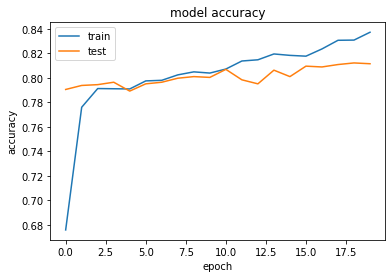

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

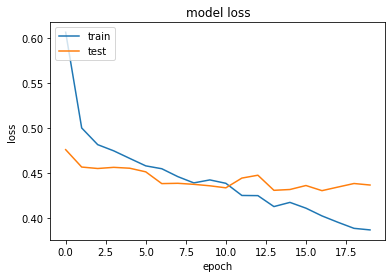

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **LOADING BEST MODEL AND PREDICTING RESULTS**

In [20]:
# from keras.models import load_model
# model = load_model('../input/finalmodel/weights-improvement-21-0.84.hdf5')

In [21]:
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [22]:
y_pre = model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

##DON'T FORGET TO UPVOTE##
##1ST NOTEBOOK KERNEL##